In [430]:
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim
import torch.utils.data
import torch.utils.data.distributed
import torchvision.datasets as datasets
from torchvision.datasets.utils import download_url
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torch.nn.functional as functions
import tarfile
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
import numpy as np

In [66]:
#Loading the data onto the system.
#Different way of downloading was used due to problems with 
##class_num = 100
#trainset = datasets.CIFAR100(root='./data', train=True, download=True)
#testset = datasets.CIFAR100(root='./data', train=False, download=True)



Files already downloaded and verified
Files already downloaded and verified


In [271]:
#downloading the dataset
dataset_url = "https://s3.amazonaws.com/fast-ai-imageclas/cifar100.tgz"
download_url(dataset_url, '.')

100%|██████████| 169168619/169168619 [00:04<00:00, 34266400.11it/s]


In [272]:
# Extract from archive
with tarfile.open('./cifar100.tgz', 'r:gz') as tar:
    tar.extractall(path='./data')

/var/folders/1f/pj80vz8n2szdkjlb6bm9k7500000gn/T/ipykernel_69227/688925285.py:3: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extractall(path='./data')


In [435]:
# turn the data set into a training and test set
dataset = ImageFolder(data_dir+'/train', transform=ToTensor())
trainset, testset = torch.utils.data.random_split(dataset, [45000, 5000])

In [436]:
print(trainset)
print(testset)

TypeError: Invalid shape (3, 32, 32) for image data

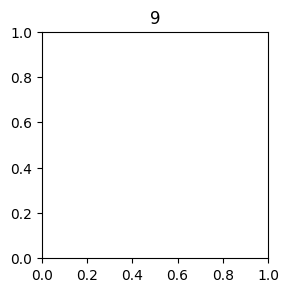

In [156]:
#looking at the images worked with the previous version of the dataset
figure = plt.figure(figsize=(10, 10))
for i in range(0, 9):
    rand = torch.randint(len(trainset), size=(1,)).item()
    img, label = trainset[rand]
    figure.add_subplot(3, 3, i+1)
    plt.title(label)
    plt.imshow(img, cmap="gray")
plt.show()

In [276]:
def kernal(im, kern):
    #created this to just work with a sample tensor to just teach myself how tensors worked in torch, but needed to updated it to take in the images from cifar100
    colors, row_img, col_im = im.shape
    row_ker, col_ker = kern.shape
    row_out, col_out = row_img - row_ker +1, col_im - col_ker +1
    out = torch.zeros([row_out, col_out])
    for i in range(row_out):
        for j in range(col_out):
            out[i,j] = torch.sum(im[1,i:i+row_ker,j:j+col_ker] * kern)
    return out 

In [277]:
#testing does not work after the new kernal 
test_im = torch.tensor([
    [1,2,3,5,6],
    [5,2,0,8,6],
    [5,2,0,9,6],
    [6,2,7,5,2]
],dtype=torch.float32)
test_ker = torch.tensor([
    [0,1,2],
    [4,5,6],
    [7,8,9]
],dtype=torch.float32)
kernal(test_im, test_ker)

ValueError: not enough values to unpack (expected 3, got 2)

In [304]:
img, label = testset[5]
#a kernal test with just one of the images and one its colors
transform = transforms.Compose([
    transforms.PILToTensor()
])
print(img.shape)
kernal(img,test_ker)

torch.Size([3, 32, 32])


tensor([[32.1412, 32.2667, 32.4667, 32.6353, 32.6275, 32.4627, 31.8667, 30.3922,
         27.8706, 24.3765, 20.7255, 16.9843, 13.8078, 11.6118, 10.7059, 11.1882,
         12.5569, 16.9804, 23.2471, 28.5176, 30.9137, 30.9608, 30.8235, 30.6941,
         30.6157, 30.5569, 30.4157, 30.2392, 30.1726, 30.1059],
        [31.6824, 31.8000, 31.8784, 31.9765, 31.9804, 32.2196, 31.6784, 30.0824,
         27.2667, 23.0784, 18.6941, 13.6902,  9.6392,  7.2039,  6.3020,  6.6275,
          7.8000, 10.8941, 16.8941, 23.5373, 28.3765, 30.2941, 30.3608, 30.2863,
         30.0784, 29.8902, 29.6980, 29.5176, 29.4980, 29.4431],
        [31.5255, 31.5412, 31.1843, 30.5529, 29.7059, 29.8980, 30.0863, 30.3216,
         29.1647, 25.9529, 21.4000, 15.6353, 11.1098,  8.3804,  7.1725,  6.3098,
          5.8863,  7.0235, 10.7843, 16.2196, 20.8980, 23.9804, 25.0314, 25.8118,
         26.9451, 28.3569, 29.6353, 30.3569, 30.6392, 30.4627],
        [29.7804, 27.9608, 26.5490, 25.2157, 23.0627, 22.4431, 25.0902, 29.6980

In [399]:
class Cifar100_model():
    def __init__(self):
        super().__init__()
        self.nn = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            ##nn.Dropout(0.4),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            ##nn.Dropout(0.4),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            ##nn.Dropout(0.4),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Flatten(0,-1),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 100)
        )
    def forward(self,imgin):
        return self.nn(imgin)

In [444]:
model_1 = Cifar100_model()
for images, labels in trainset:
    print('images.shape:', images.shape)
    out = model_1.nn(images)
    print('out.shape:', out.shape)
    break


images.shape: torch.Size([3, 32, 32])
out.shape: torch.Size([100])


In [437]:

def train(model, epochs, learning_rate, train_set, test_set):
    a = torch.ones(100)
    #print(a)
    labels = torch.diag(a,0)
    #print(labels)
    losses = []
    optimizer = torch.optim.SGD(model.parameters(), learning_rate)
    for i in range(epochs):
        model.train()
        m = 0.0
        cor_t = 0.0
        for j in train_set: ##Training
            optimizer.zero_grad() #zeroing out the grad for this training
            img, lab = j
            lab_r = labels[lab]
            ret = model(img)
            loss = functions.cross_entropy(ret,lab_r) #
            loss.backward()
            optimizer.step() #training 
            optimizer.zero_grad()
            if m % 3000 == 0: ##printing so that I know the speed
                print(m,end=', ')
            m+=1
            max = ret[0]
            index = 0
            for q in range(100): #getting the percent correct 
                if ret[q] > max:
                    index = q
                    max = ret[q]
            if index == lab:
                cor_t += 1
            losses.append(loss)
        t = 0.
        cor = 0.
        for k in test_set:
            model.eval()
            img, lab = k
            lab_r = labels[lab]
            ret_test = model(img)
            loss_test = functions.cross_entropy(ret_test,lab_r) #getting the testing accuracy
            if t % 1000 == 0:
                print(t,end=', ')
            max = ret_test[0]
            index = 0
            for q in range(100):
                if ret_test[q] > max:
                    index = q
                    max = ret_test[q]
            if index == lab:
                cor += 1
            t+=1
        acc = cor/t
        acc_t = cor_t/m
        print("")
        print("epoch [{}], train_loss: {:.4f}, train_acc: {:.4f}, test_loss: {:.4f}, test_acc: {:.4f}".format(
        i, torch.stack(losses).mean().item(), acc_t, loss_test.detach(), acc))

            



In [445]:
#training the model 
print(len(trainset))
train(model_1.nn, 4, 0.01, trainset, testset)


45000
0.0, 3000.0, 6000.0, 9000.0, 12000.0, 15000.0, 18000.0, 21000.0, 24000.0, 27000.0, 30000.0, 33000.0, 36000.0, 39000.0, 42000.0, 0.0, 1000.0, 2000.0, 3000.0, 4000.0, 
epoch [0], train_loss: 2.8273, train_acc: 0.1172, test_loss: 2.6981, test_acc: 0.1742
0.0, 3000.0, 6000.0, 9000.0, 12000.0, 15000.0, 18000.0, 21000.0, 24000.0, 27000.0, 30000.0, 33000.0, 36000.0, 39000.0, 42000.0, 0.0, 1000.0, 2000.0, 3000.0, 4000.0, 
epoch [1], train_loss: 2.6276, train_acc: 0.2355, test_loss: 3.6809, test_acc: 0.2958
0.0, 3000.0, 6000.0, 9000.0, 12000.0, 15000.0, 18000.0, 21000.0, 24000.0, 27000.0, 30000.0, 33000.0, 36000.0, 39000.0, 42000.0, 0.0, 1000.0, 2000.0, 3000.0, 4000.0, 
epoch [2], train_loss: 2.4896, train_acc: 0.3149, test_loss: 3.9310, test_acc: 0.3330
0.0, 3000.0, 6000.0, 9000.0, 12000.0, 15000.0, 18000.0, 21000.0, 24000.0, 27000.0, 30000.0, 33000.0, 36000.0, 39000.0, 42000.0, 0.0, 1000.0, 2000.0, 3000.0, 4000.0, 
epoch [3], train_loss: 2.3984, train_acc: 0.3451, test_loss: 3.8800, tes

In [446]:
## code found on https://stackoverflow.com/questions/49201236/check-the-total-number-of-parameters-in-a-pytorch-model

from prettytable import PrettyTable

def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad:
            continue
        params = parameter.numel()
        table.add_row([name, params])
        total_params += params
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params
    
count_parameters(model_1.nn)

+-----------+------------+
|  Modules  | Parameters |
+-----------+------------+
|  0.weight |    864     |
|   0.bias  |     32     |
|  3.weight |   18432    |
|   3.bias  |     64     |
|  6.weight |   36864    |
|   6.bias  |     64     |
|  9.weight |   36864    |
|   9.bias  |     64     |
| 12.weight |   73728    |
|  12.bias  |    128     |
| 16.weight |   32768    |
|  16.bias  |    256     |
| 18.weight |   65536    |
|  18.bias  |    256     |
| 20.weight |   25600    |
|  20.bias  |    100     |
+-----------+------------+
Total Trainable Params: 291620


291620

In [447]:
import pandas as pd
params = {}
for name, param in model_1.nn.named_parameters():
    params[name] = param.detach().cpu().numpy().flatten()
#print(params)
df = pd.DataFrame({ key:pd.Series(value) for key, value in params.items() })
df.to_csv('model_params.csv', index= False)